# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

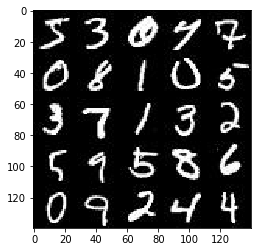

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

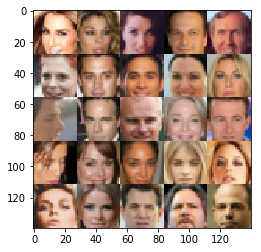

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Users/gvalsan/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),'real_input')
    z_input = tf.placeholder(tf.float32,(None,z_dim),'z_input')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')
    

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        h1Conv = tf.layers.conv2d(images, 64, 5, 2, 'same')
        h1relu = tf.maximum(alpha * h1Conv, h1Conv)
        
        h2Conv = tf.layers.conv2d(h1relu, 128, 5, 2, 'same')
        h2Conv = tf.layers.batch_normalization(h2Conv, training=True)
        h2relu = tf.maximum(alpha * h2Conv, h2Conv)
        
        h3Conv = tf.layers.conv2d(h2relu, 256, 5, 2, 'same')
        h3Conv = tf.layers.batch_normalization(h3Conv, training=True)
        h3relu = tf.maximum(alpha * h3Conv, h3Conv)
        
        flatten = tf.reshape(h3relu, (-1, 4*4*256))
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function 
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        
        alpha = 0.2
        
        fullyConnected1 = tf.layers.dense(z, 28*28*512)
        fullyConnected1 = tf.reshape(fullyConnected1, (-1, 28, 28, 512))
        fullyConnected1 = tf.layers.batch_normalization(fullyConnected1, training=is_train)
        fullyConnected1 = tf.maximum(alpha*fullyConnected1, fullyConnected1)
        
        # Starting Conv Transpose Stack
        h2deconv = tf.layers.conv2d_transpose(fullyConnected1, 256, 5, 1, 'same')
        h2deconv = tf.layers.batch_normalization(h2deconv, training=is_train)
        h2relu = tf.maximum(alpha * h2deconv, h2deconv)
        
        h3deconv = tf.layers.conv2d_transpose(h2relu, 128, 5, 1, 'same')
        h3deconv = tf.layers.batch_normalization(h3deconv, training=is_train)
        h3relu = tf.maximum(alpha * h3deconv, h3deconv)
        
        # Logits
        logits = tf.layers.conv2d_transpose(h3relu, out_channel_dim, 5, 1, 'same')
        
        # Output
        out = tf.tanh(logits)
        
        return out




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    generator_model = generator(input_z, out_channel_dim)
    discriminator_model_real, discriminator_logits_real = discriminator(input_real)
    discriminator_model_fake, discriminator_logits_fake = discriminator(generator_model, reuse=True)
    
    discriminator_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_real, 
                                                              labels=tf.ones_like(discriminator_model_real) * 0.9))
    discriminator_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, 
                                                              labels=tf.zeros_like(discriminator_model_fake)))
    discriminator_loss = discriminator_loss_real + discriminator_loss_fake

    generator_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake,
                                                         labels=tf.ones_like(discriminator_model_fake)))
    
    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    tvars = tf.trainable_variables()
    discriminator_vars = [var for var in tvars if var.name.startswith('discriminator')]
    generator_vars = [var for var in tvars if var.name.startswith('generator')]

    # Optimize
    discriminator_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_vars)
    #generator_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=generator_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    generator_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(generator_updates):
        generator_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=generator_vars)

    return discriminator_train_opt, generator_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()
    real_input, z_input, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    discriminator_loss, generator_loss = model_loss(real_input, z_input, data_shape[3])
    discriminator_opt, generator_opt = model_opt(discriminator_loss, generator_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images * 2
                steps += 1
            
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(discriminator_opt, feed_dict={real_input: batch_images, z_input: batch_z, lr: learning_rate})
                _ = sess.run(generator_opt, feed_dict={z_input: batch_z})
                
                if steps % 100 == 0:
                    # At the end of every 10 epochs, get the losses and print them out
                    train_loss_discriminator = discriminator_loss.eval({z_input: batch_z, real_input: batch_images})
                    train_loss_generator = generator_loss.eval({z_input: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_discriminator),
                          "Generator Loss: {:.4f}".format(train_loss_generator))
                    
                    _ = show_generator_output(sess, 1, z_input, data_shape[3], data_image_mode)
               
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1858... Generator Loss: 0.9689


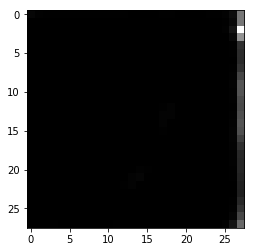

Epoch 1/2... Discriminator Loss: 1.0463... Generator Loss: 1.2995


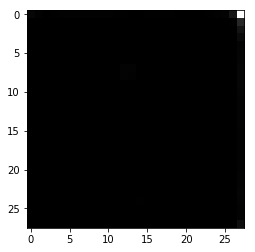

Epoch 1/2... Discriminator Loss: 1.3078... Generator Loss: 0.6730


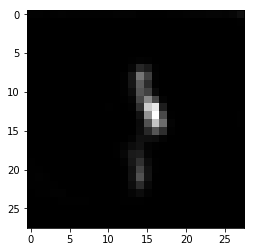

Epoch 1/2... Discriminator Loss: 1.7487... Generator Loss: 0.3846


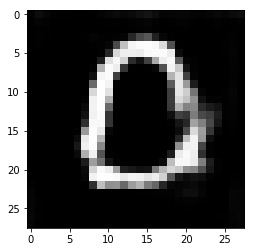

Epoch 1/2... Discriminator Loss: 1.2489... Generator Loss: 1.2105


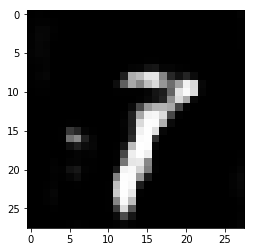

Epoch 1/2... Discriminator Loss: 1.1590... Generator Loss: 1.3686


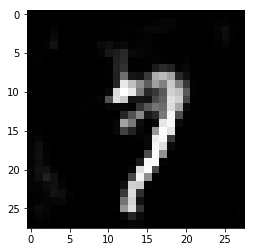

Epoch 1/2... Discriminator Loss: 1.3248... Generator Loss: 1.8176


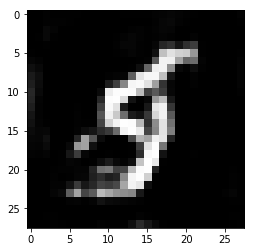

Epoch 1/2... Discriminator Loss: 1.3283... Generator Loss: 0.6154


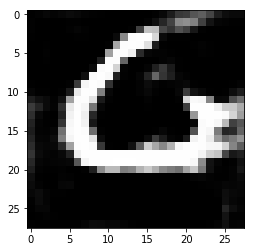

Epoch 1/2... Discriminator Loss: 1.2242... Generator Loss: 0.9018


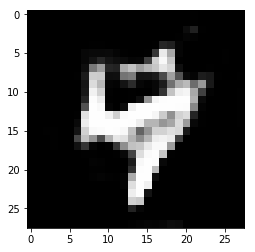

Epoch 2/2... Discriminator Loss: 1.1100... Generator Loss: 0.9204


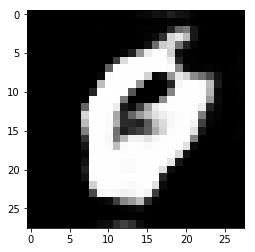

Epoch 2/2... Discriminator Loss: 1.6819... Generator Loss: 0.4259


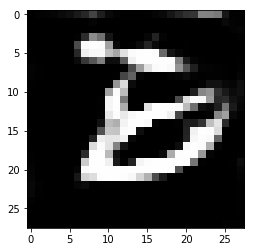

Epoch 2/2... Discriminator Loss: 0.9068... Generator Loss: 1.4201


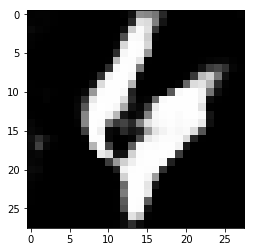

Epoch 2/2... Discriminator Loss: 0.9612... Generator Loss: 1.7290


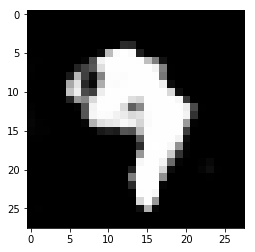

Epoch 2/2... Discriminator Loss: 1.1848... Generator Loss: 0.9061


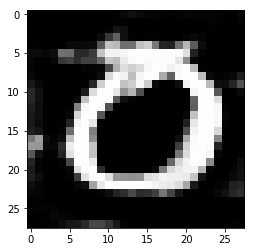

Epoch 2/2... Discriminator Loss: 1.2492... Generator Loss: 0.7997


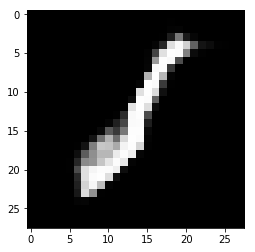

Epoch 2/2... Discriminator Loss: 0.9657... Generator Loss: 1.1778


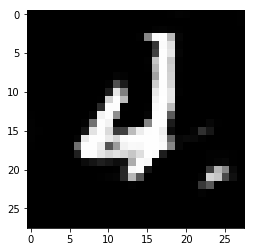

Epoch 2/2... Discriminator Loss: 1.9159... Generator Loss: 0.3427


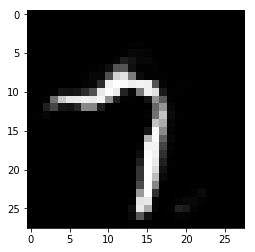

Epoch 2/2... Discriminator Loss: 1.1392... Generator Loss: 1.0956


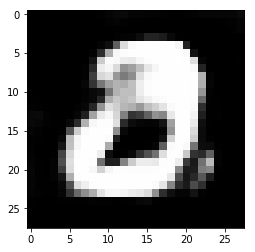

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6258... Generator Loss: 2.3656


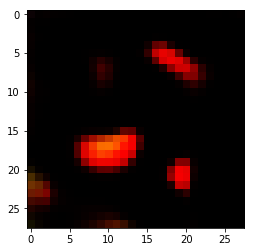

Epoch 1/1... Discriminator Loss: 0.3753... Generator Loss: 6.1690


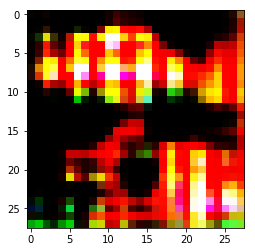

Epoch 1/1... Discriminator Loss: 0.3312... Generator Loss: 6.2697


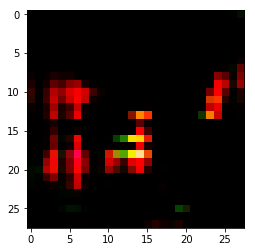

Epoch 1/1... Discriminator Loss: 0.4277... Generator Loss: 4.8158


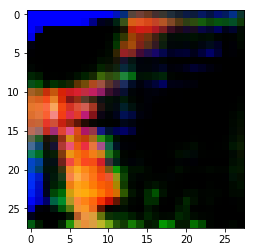

Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 0.6225


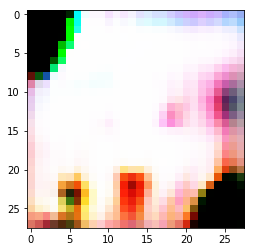

Epoch 1/1... Discriminator Loss: 1.8652... Generator Loss: 3.5136


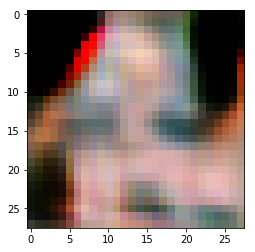

Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.7324


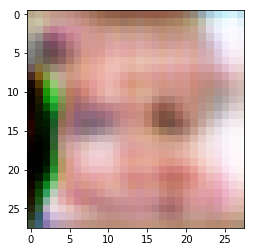

Epoch 1/1... Discriminator Loss: 0.8313... Generator Loss: 1.2337


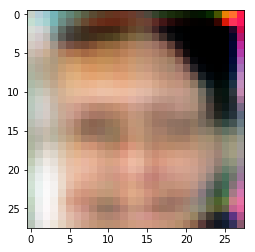

Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 1.7125


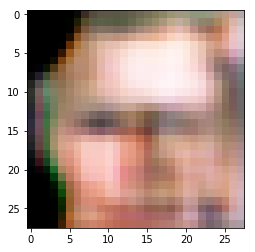

Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.7144


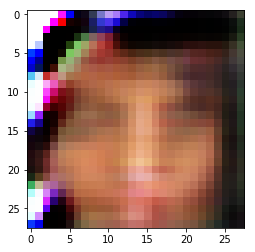

Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 0.9293


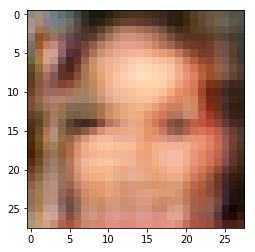

Epoch 1/1... Discriminator Loss: 1.0519... Generator Loss: 1.0204


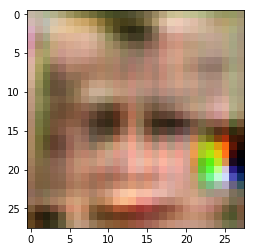

Epoch 1/1... Discriminator Loss: 1.5266... Generator Loss: 0.4781


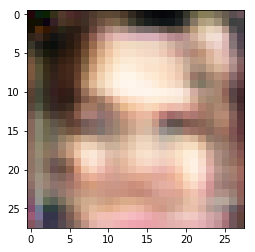

Epoch 1/1... Discriminator Loss: 1.7248... Generator Loss: 0.7023


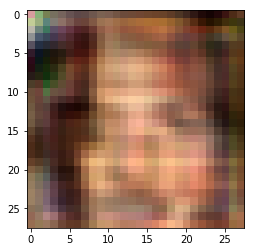

Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 0.5653


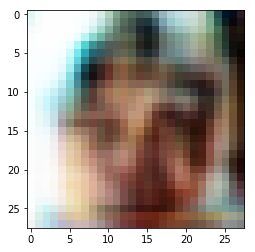

Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.7084


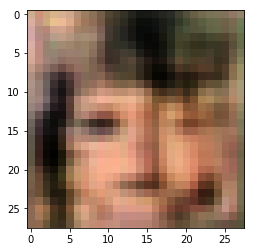

Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 0.7548


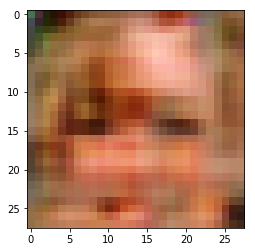

Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.6558


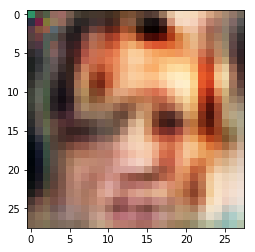

Epoch 1/1... Discriminator Loss: 1.0209... Generator Loss: 0.9152


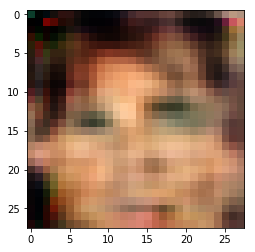

Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.7386


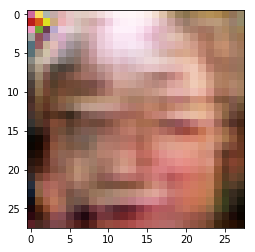

Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.6360


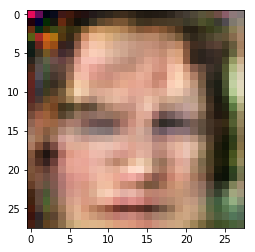

Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.7546


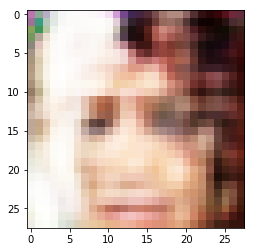

Epoch 1/1... Discriminator Loss: 1.5440... Generator Loss: 0.5444


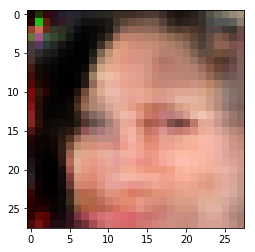

Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.7147


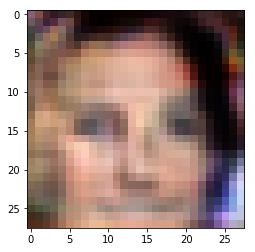

Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.8617


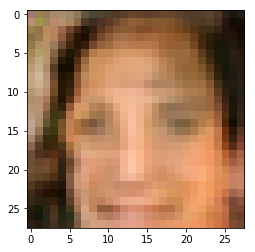

Epoch 1/1... Discriminator Loss: 1.2603... Generator Loss: 0.8038


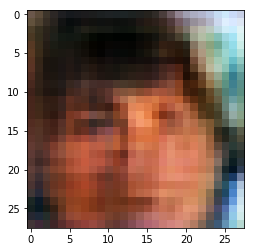

Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 0.8362


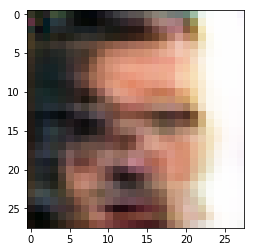

Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.6595


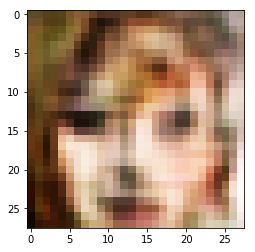

Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.7227


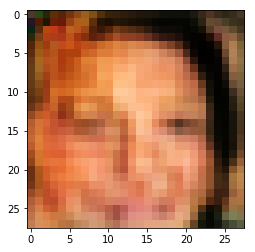

Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 0.8963


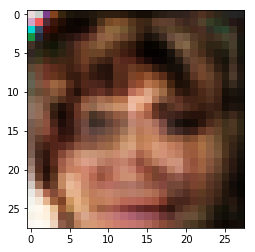

Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.8151


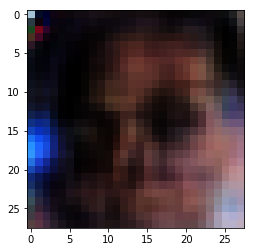

Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.8637


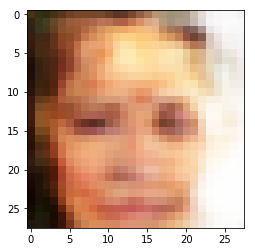

Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.7589


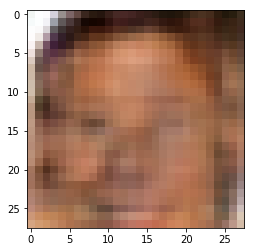

Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.7361


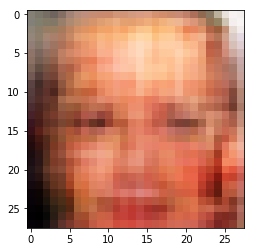

Epoch 1/1... Discriminator Loss: 1.5568... Generator Loss: 0.5878


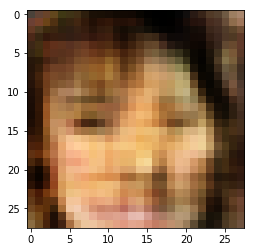

Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.6892


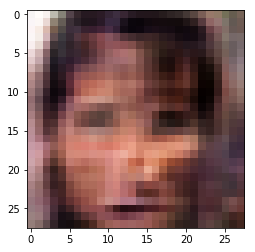

Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7518


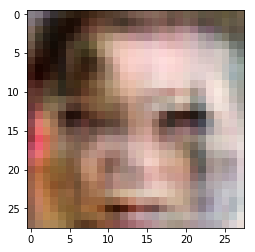

Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.7469


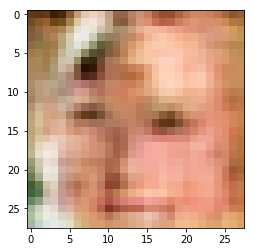

Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.7728


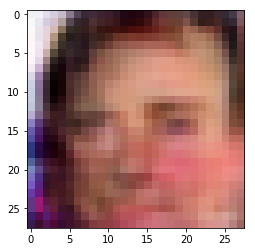

Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.7872


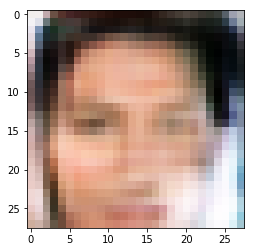

Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.7611


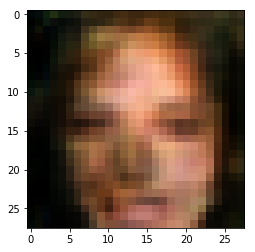

Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.6901


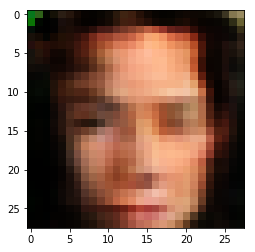

Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.8227


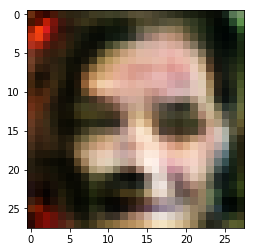

Epoch 1/1... Discriminator Loss: 1.4767... Generator Loss: 0.7229


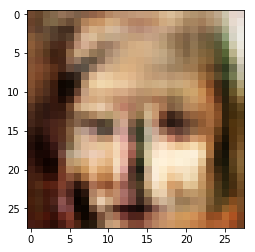

Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.7472


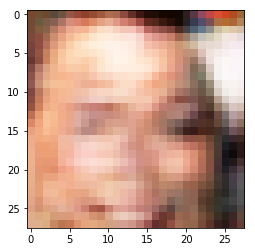

Epoch 1/1... Discriminator Loss: 1.5237... Generator Loss: 0.6417


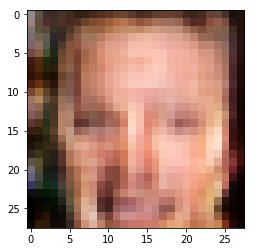

Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.8031


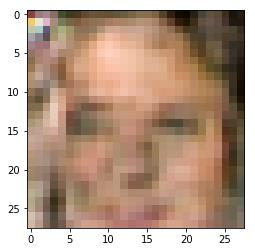

Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.7748


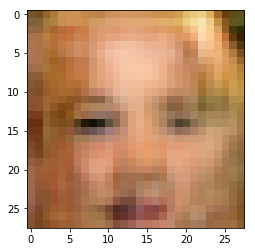

Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.8083


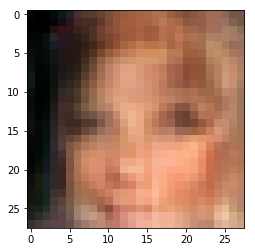

Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7978


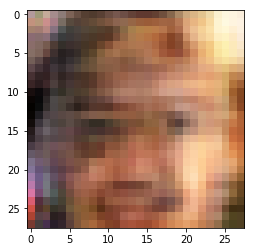

Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.8324


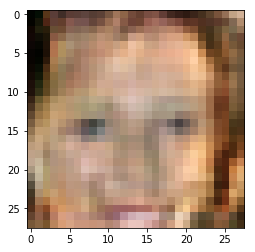

Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.7864


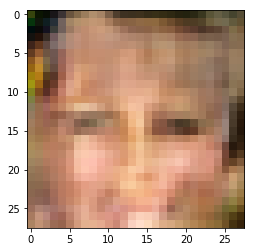

Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.6577


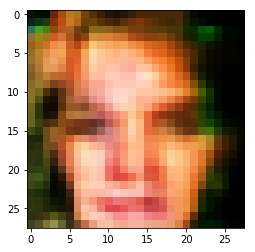

Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.8365


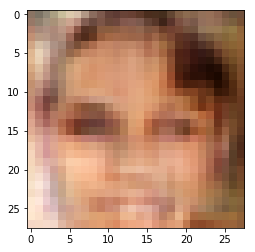

Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7438


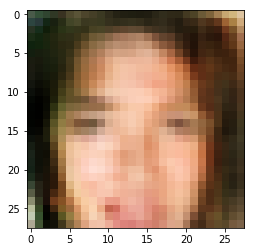

Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.8289


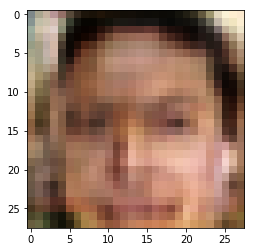

Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.8273


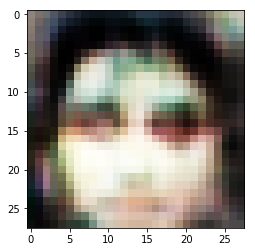

Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.8647


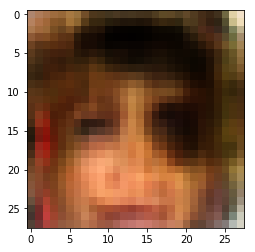

Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.7997


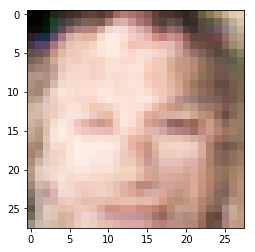

Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.7524


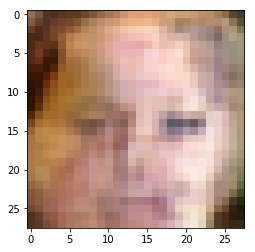

Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 0.8550


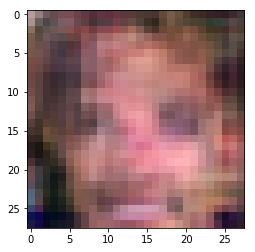

Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.7720


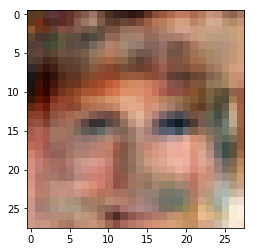

Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.7297


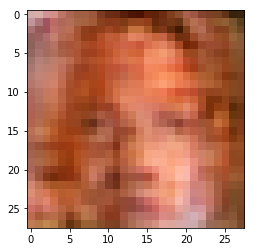

Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.7427


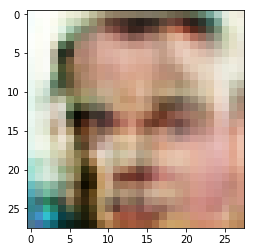

Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.5698


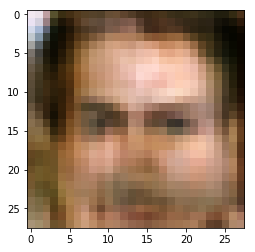

Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.6187


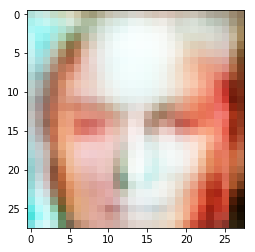

Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.7496


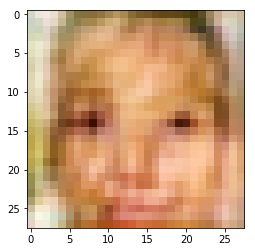

Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.7610


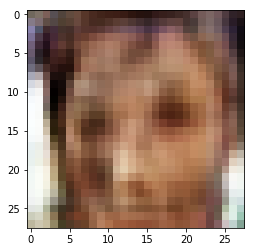

Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.6972


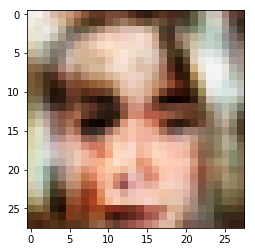

Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.8168


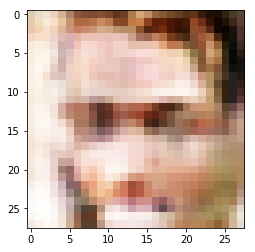

Epoch 1/1... Discriminator Loss: 1.4818... Generator Loss: 0.6547


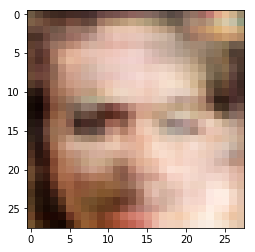

Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.7312


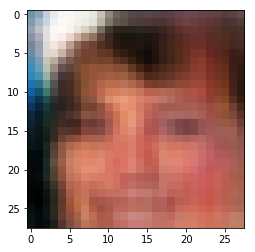

Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.7664


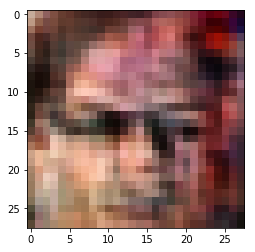

Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.6511


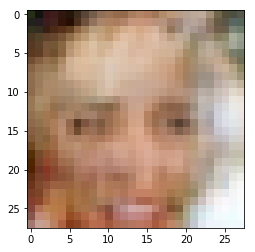

Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 0.8560


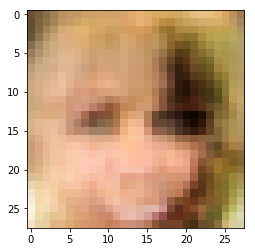

Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.6493


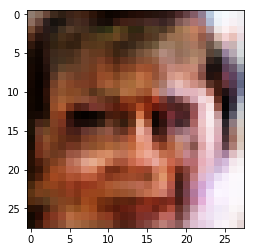

Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.8027


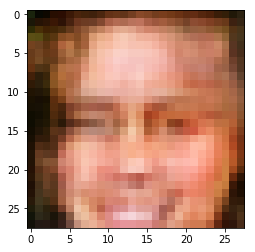

Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.7916


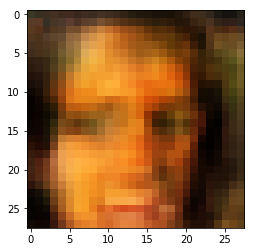

Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.8063


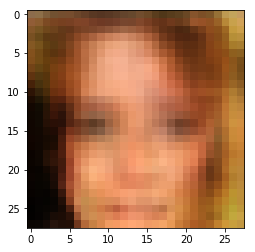

Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.7744


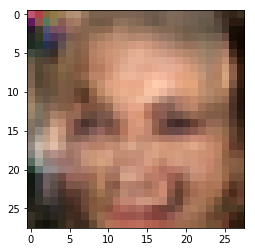

Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.7523


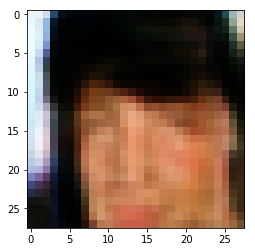

Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.7880


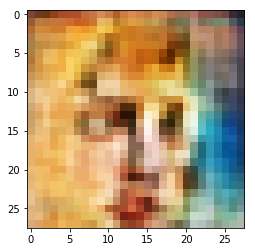

Epoch 1/1... Discriminator Loss: 1.5201... Generator Loss: 0.5329


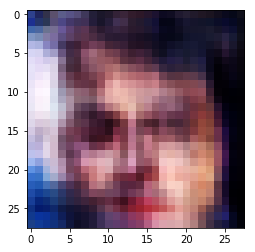

Epoch 1/1... Discriminator Loss: 1.5080... Generator Loss: 0.7052


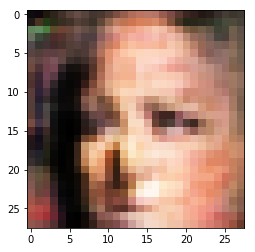

Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.7283


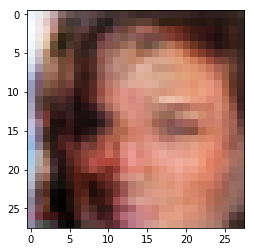

Epoch 1/1... Discriminator Loss: 1.5096... Generator Loss: 0.7757


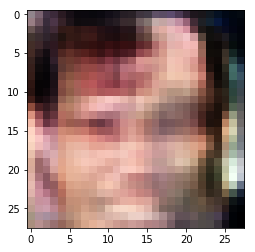

Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7384


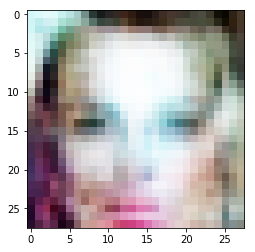

Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.7439


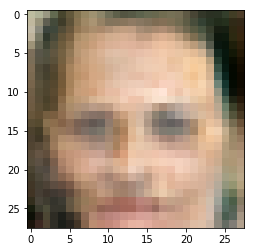

Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.7790


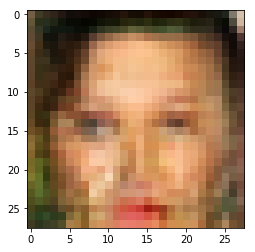

Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.7311


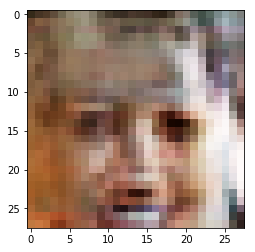

Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.7371


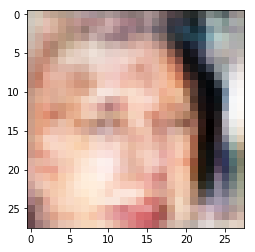

Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.6287


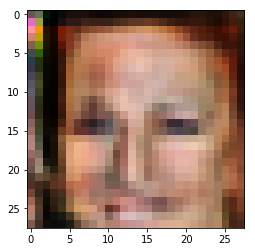

Epoch 1/1... Discriminator Loss: 1.5086... Generator Loss: 0.6581


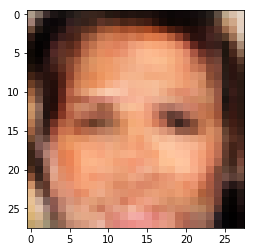

Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.7900


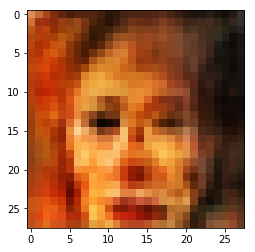

Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.7636


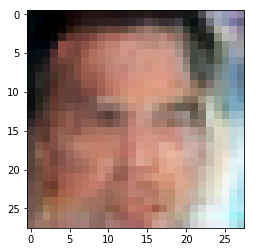

Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.7035


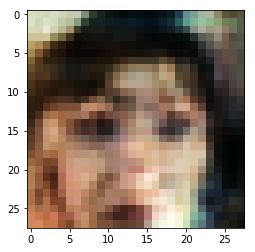

Epoch 1/1... Discriminator Loss: 1.4863... Generator Loss: 0.6904


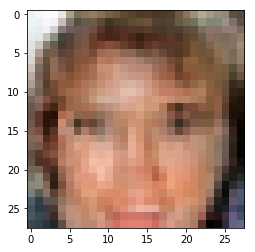

Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.8627


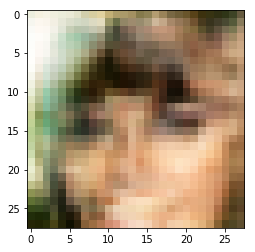

Epoch 1/1... Discriminator Loss: 1.5527... Generator Loss: 0.5637


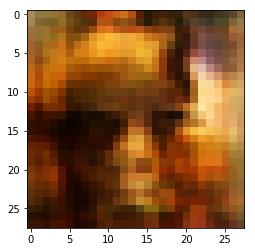

Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.6285


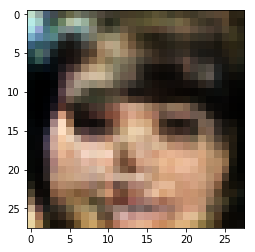

Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 0.9249


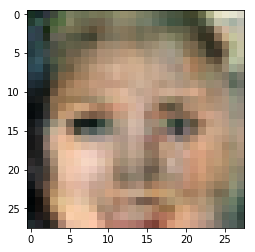

Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.7826


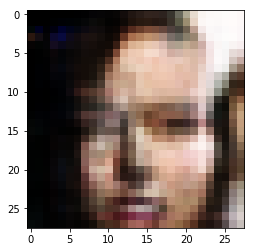

Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.6567


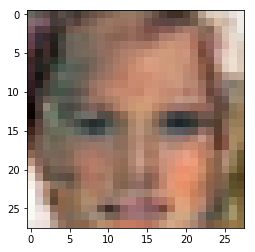

Epoch 1/1... Discriminator Loss: 1.5501... Generator Loss: 0.4333


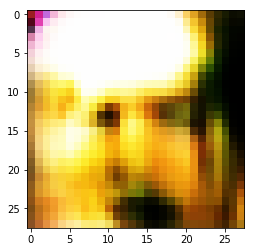

Epoch 1/1... Discriminator Loss: 0.3321... Generator Loss: 7.4514


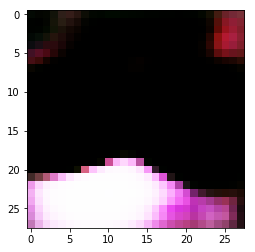

Epoch 1/1... Discriminator Loss: 0.3318... Generator Loss: 5.9230


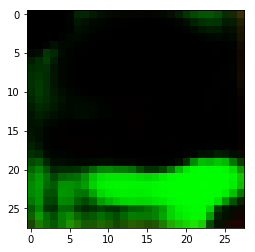

Epoch 1/1... Discriminator Loss: 0.3270... Generator Loss: 7.4737


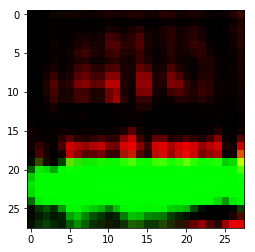

Epoch 1/1... Discriminator Loss: 0.3291... Generator Loss: 7.4089


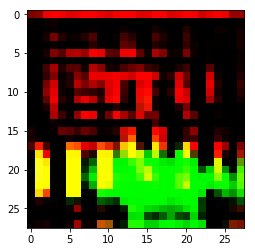

Epoch 1/1... Discriminator Loss: 0.3325... Generator Loss: 9.6250


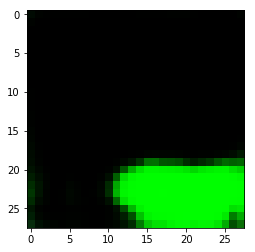

Epoch 1/1... Discriminator Loss: 0.3270... Generator Loss: 8.9105


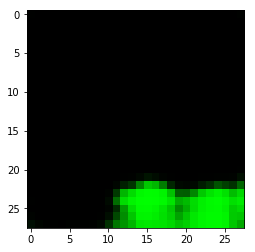

Epoch 1/1... Discriminator Loss: 0.3263... Generator Loss: 8.8506


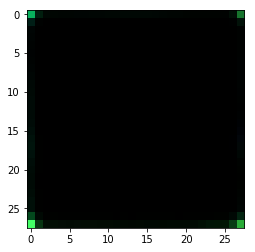

Epoch 1/1... Discriminator Loss: 0.3262... Generator Loss: 8.8055


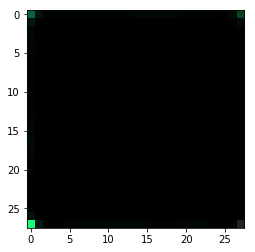

Epoch 1/1... Discriminator Loss: 0.3259... Generator Loss: 9.1679


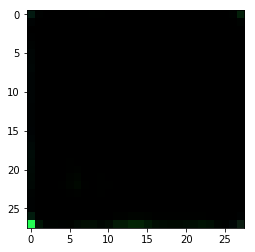

Epoch 1/1... Discriminator Loss: 0.3253... Generator Loss: 9.2492


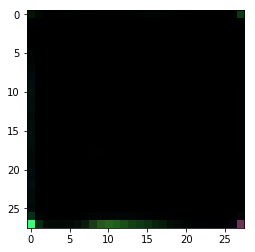

Epoch 1/1... Discriminator Loss: 0.3256... Generator Loss: 9.2461


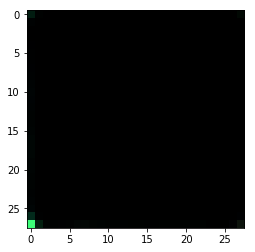

Epoch 1/1... Discriminator Loss: 0.3257... Generator Loss: 9.3407


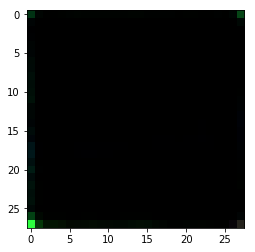

Epoch 1/1... Discriminator Loss: 0.3253... Generator Loss: 9.4495


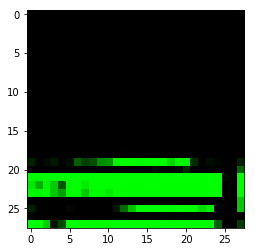

Epoch 1/1... Discriminator Loss: 0.3272... Generator Loss: 6.8515


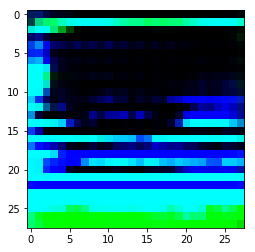

Epoch 1/1... Discriminator Loss: 0.3263... Generator Loss: 7.6305


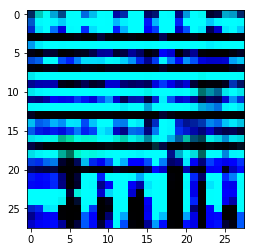

Epoch 1/1... Discriminator Loss: 0.3260... Generator Loss: 11.3485


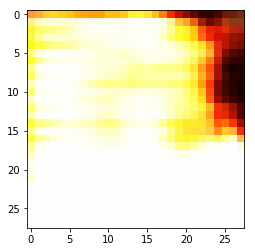

Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.6719


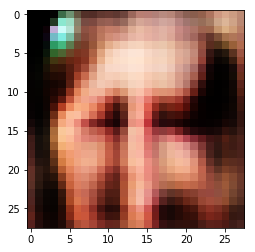

Epoch 1/1... Discriminator Loss: 2.2905... Generator Loss: 0.2321


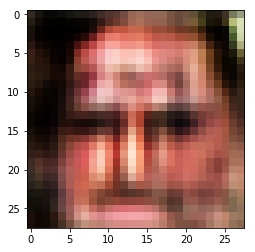

Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 0.6637


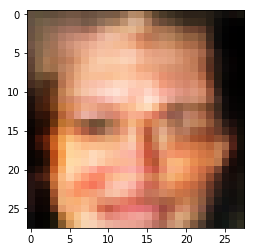

Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 0.6875


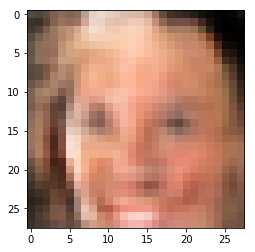

Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.5678


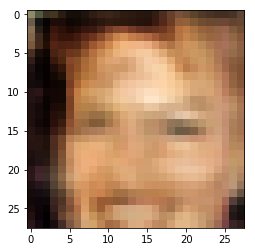

Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.7310


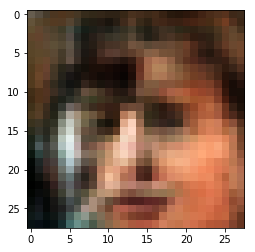

Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.7453


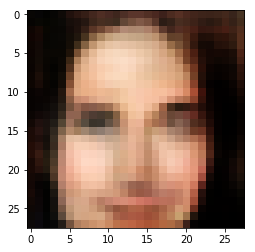

Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.7498


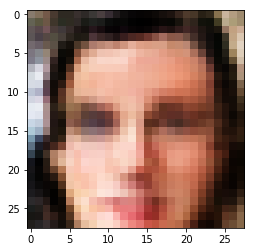

Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.6723


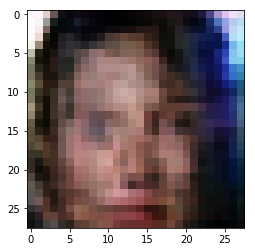

Epoch 1/1... Discriminator Loss: 1.1759... Generator Loss: 0.8234


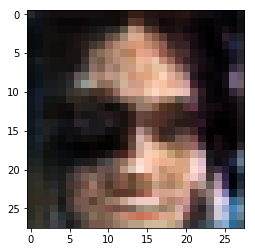

Epoch 1/1... Discriminator Loss: 1.6682... Generator Loss: 0.4915


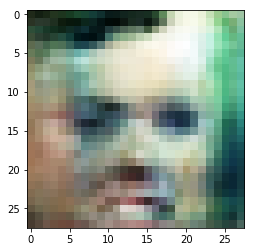

Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.7628


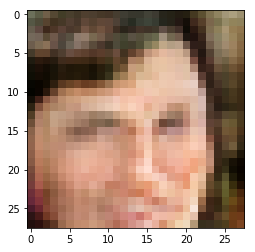

Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.7317


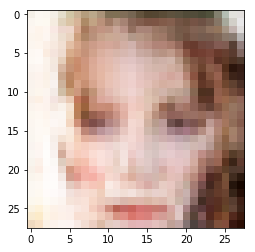

Epoch 1/1... Discriminator Loss: 1.1567... Generator Loss: 0.8604


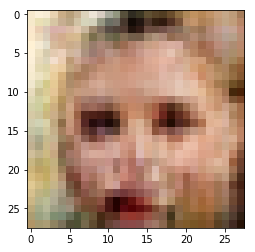

Epoch 1/1... Discriminator Loss: 1.6003... Generator Loss: 0.5888


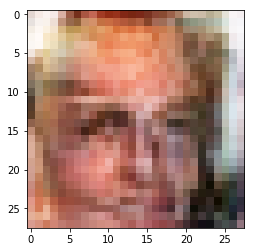

Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.6601


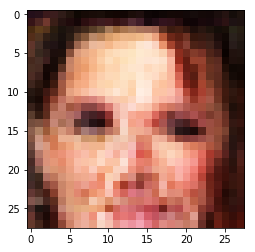

Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.7931


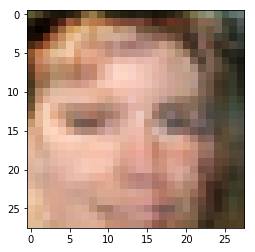

Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.9109


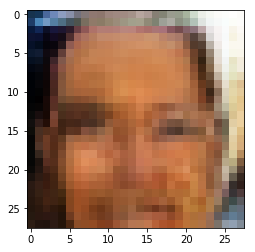

Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 0.7174


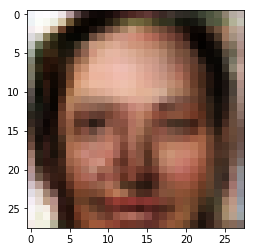

Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.6335


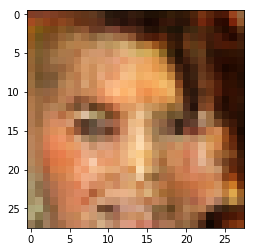

Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.7797


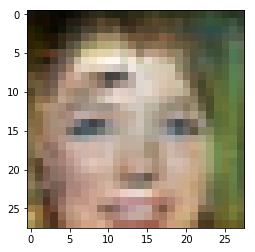

Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.7358


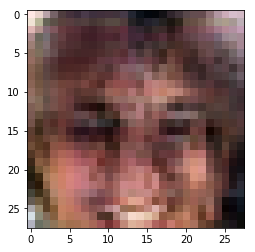

Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.7429


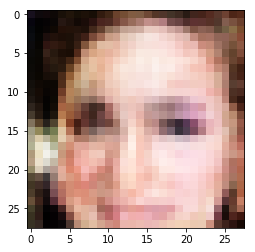

Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.7385


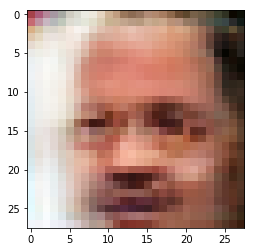

Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.8219


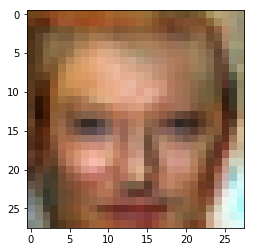

Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.5657


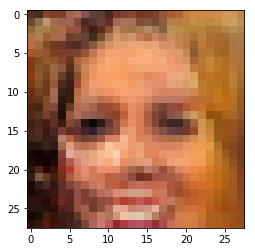

Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.7713


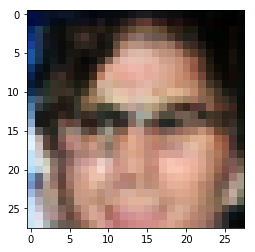

Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.6761


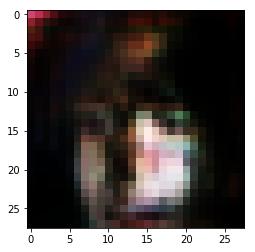

Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.7319


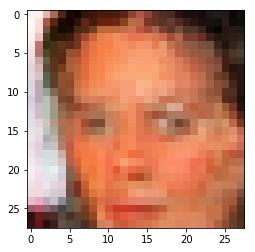

Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.6663


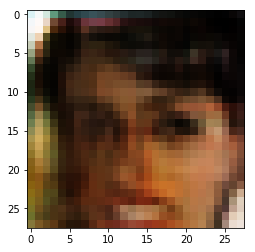

Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.7503


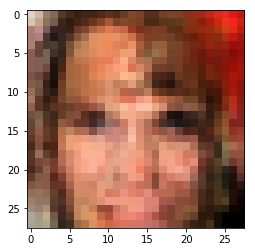

Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.7800


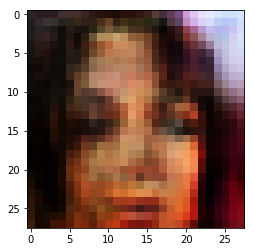

Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.7403


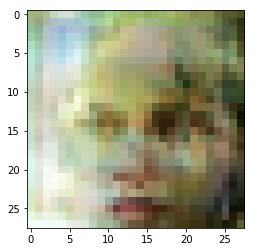

Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.6348


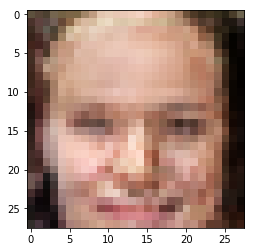

Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 0.7700


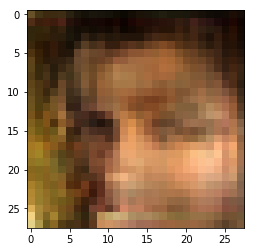

Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7332


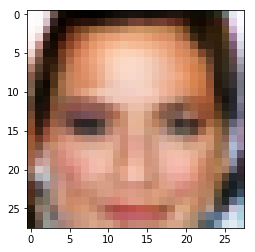

Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.7428


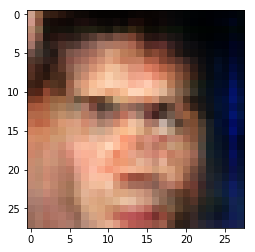

Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.8153


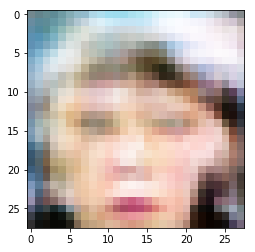

Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.6635


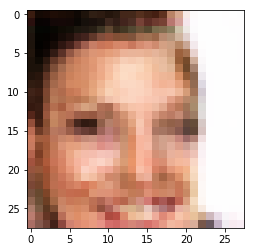

Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.7043


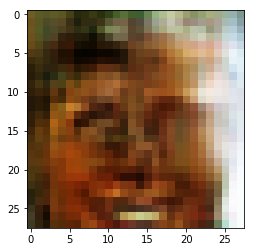

In [ ]:
batch_size = 10
z_dim = 100
learning_rate = 0.003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.